# Effect Classification

In [1]:
import torch
from torch import nn
import torchaudio
import os
import numpy as np
import matplotlib.pyplot as plt

### Load dataset

In [2]:
from src.gtfxdataset import GtFxDataset

AUDIO_DIR = "_assets/DATASET/GT-FX-C51/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "annotation.csv")

SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*3

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=1050,
    n_mels=64,
    # power=2
)

spectrogram = torchaudio.transforms.Spectrogram(
    power=2,
    n_fft=127,
    win_length= 127,
    hop_length= 1040,
    normalized=True
)

mfcc = torchaudio.transforms.MFCC(
    sample_rate = SAMPLE_RATE, 
    n_mfcc = 64,
    melkwargs = {
        "n_fft": 1024,
        "hop_length": 1030,
        "n_mels": 64,
        "center": False})

fxData = GtFxDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

signal, _, _, _, _ = fxData[0]
print(f"There are {len(fxData)} samples in the dataset.")
print(f"Shape of signal: {signal.shape}")
    

Using device cpu
There are 26100 samples in the dataset.
Shape of signal: torch.Size([1, 64, 64])


#### Split dataset into train and test sets

In [3]:
from src.classifier import train

BATCH_SIZE = 128

split_ratio = [0.8, 0.1, 0.1]
train_set, test_set, val_set = torch.utils.data.random_split(fxData, lengths=split_ratio)

train_dataloader = train.create_data_loader(train_set, BATCH_SIZE)
test_dataloader = train.create_data_loader(test_set, BATCH_SIZE)
val_dataloader = train.create_data_loader(val_set, BATCH_SIZE)


#### Model training

In [4]:
from src.classifier import model

LEARNING_RATE = 0.001
EPOCHS = 5

WEIGHTS_DIR = "_weights/"
WEIGHTS_FILE = os.path.join(WEIGHTS_DIR, "c51_classify.pth")

if not os.path.exists('%s' % WEIGHTS_DIR):
    os.makedirs('%s' % WEIGHTS_DIR)

# construct model and assign it to device
cnn = model.Classifier().to(device)

# initialise loss funtion + optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train model
train.train(cnn,
            train_dataloader,
            test_dataloader,
            loss_fn,
            optimiser,
            device,
            EPOCHS)

# save model
torch.save(cnn.state_dict(), WEIGHTS_FILE)
print("Trained feed forward net saved at %s" %(WEIGHTS_FILE))

Epoch 1
loss: 3.786309  [  0/20992]
loss: 1.531476  [2560/20992]
loss: 1.002345  [5120/20992]
loss: 0.638665  [7680/20992]
loss: 0.424399  [10240/20992]
loss: 0.307991  [12800/20992]
loss: 0.171696  [15360/20992]
loss: 0.217175  [17920/20992]
loss: 0.094921  [20480/20992]
distortion: Accuracy: 99.7%, avg loss: 0.014565
chorus: Accuracy: 99.7%, avg loss: 0.017632
tremolo: Accuracy: 100.0%, avg loss: 0.004516
delay: Accuracy: 99.5%, avg loss: 0.030114
reverb: Accuracy: 99.5%, avg loss: 0.018862
Total: avg loss: 0.085688

---------------------------
Epoch 2
loss: 0.061485  [  0/20992]
loss: 0.076111  [2560/20992]
loss: 0.034880  [5120/20992]
loss: 0.154410  [7680/20992]
loss: 0.026568  [10240/20992]
loss: 0.057144  [12800/20992]
loss: 0.023082  [15360/20992]
loss: 0.015104  [17920/20992]
loss: 0.011613  [20480/20992]
distortion: Accuracy: 99.7%, avg loss: 0.008216
chorus: Accuracy: 100.0%, avg loss: 0.003079
tremolo: Accuracy: 100.0%, avg loss: 0.001405
delay: Accuracy: 99.5%, avg loss: 0

#### Evaluation

distortion: Accuracy: 100.0%, avg loss: 0.002469
chorus: Accuracy: 100.0%, avg loss: 0.000878
tremolo: Accuracy: 99.8%, avg loss: 0.004850
delay: Accuracy: 99.9%, avg loss: 0.003392
reverb: Accuracy: 99.9%, avg loss: 0.002858
Total: avg loss: 0.014447

[[2080    0]
 [   1  529]]


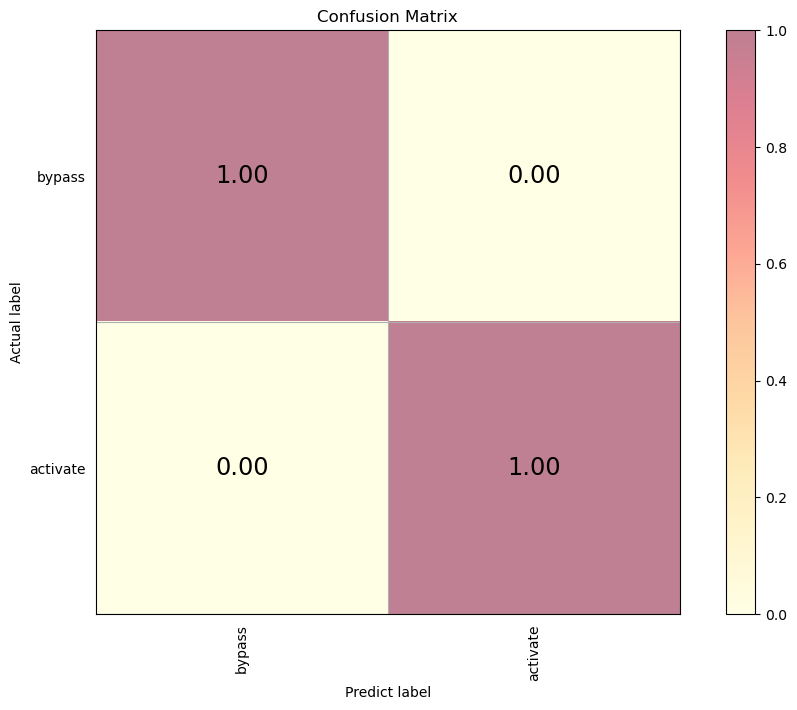

[[2107    0]
 [   1  502]]


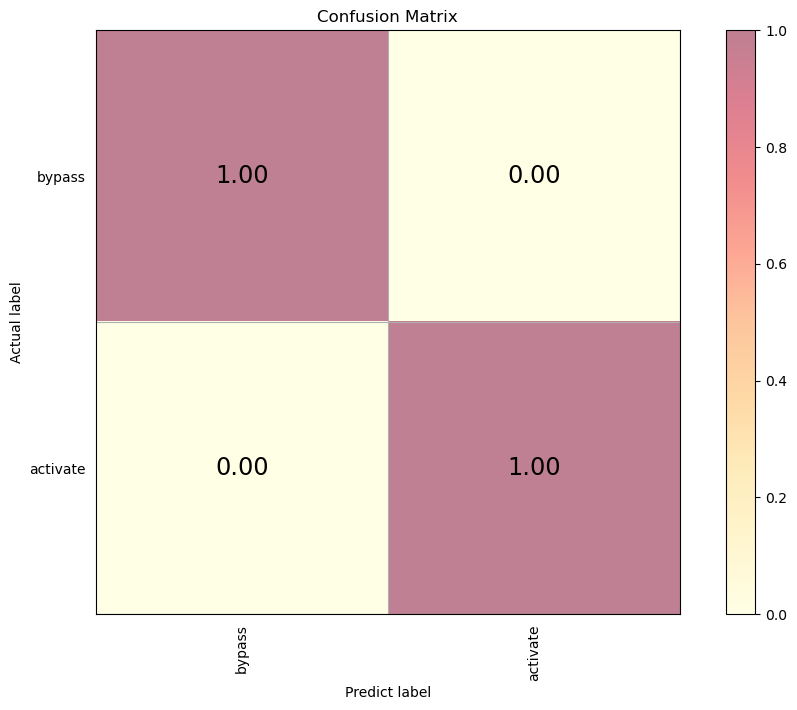

[[2073    5]
 [   0  532]]


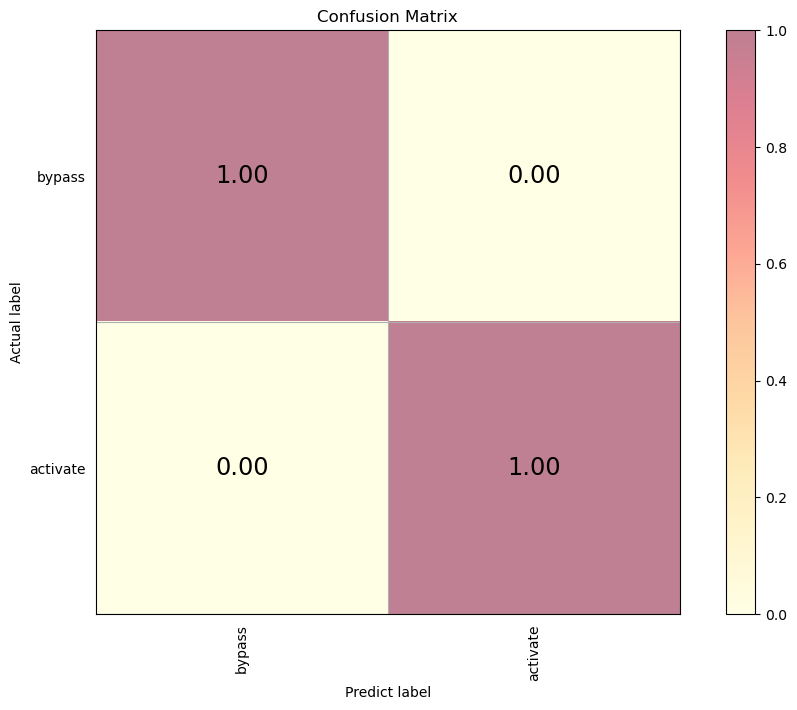

[[2102    0]
 [   2  506]]


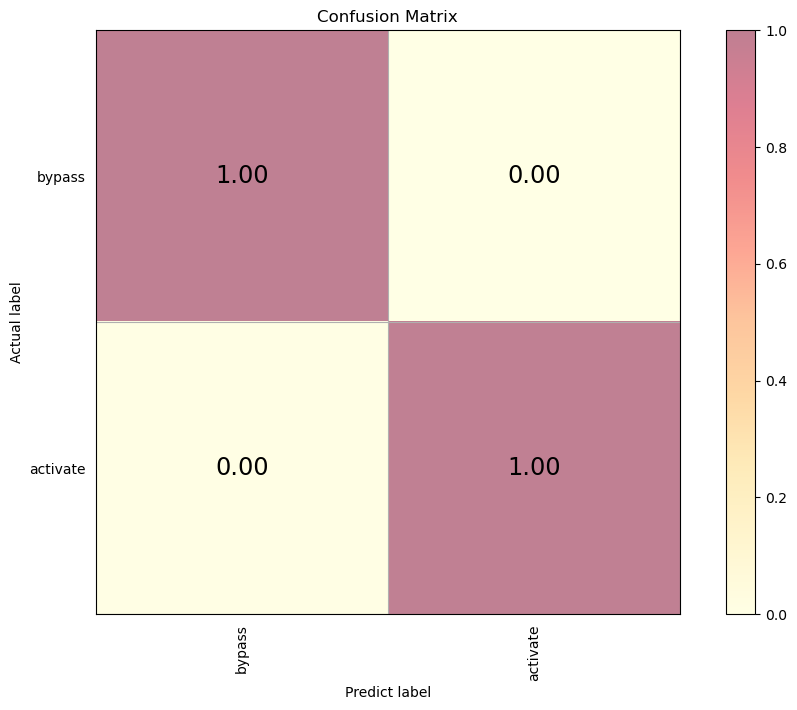

[[2071    2]
 [   0  537]]


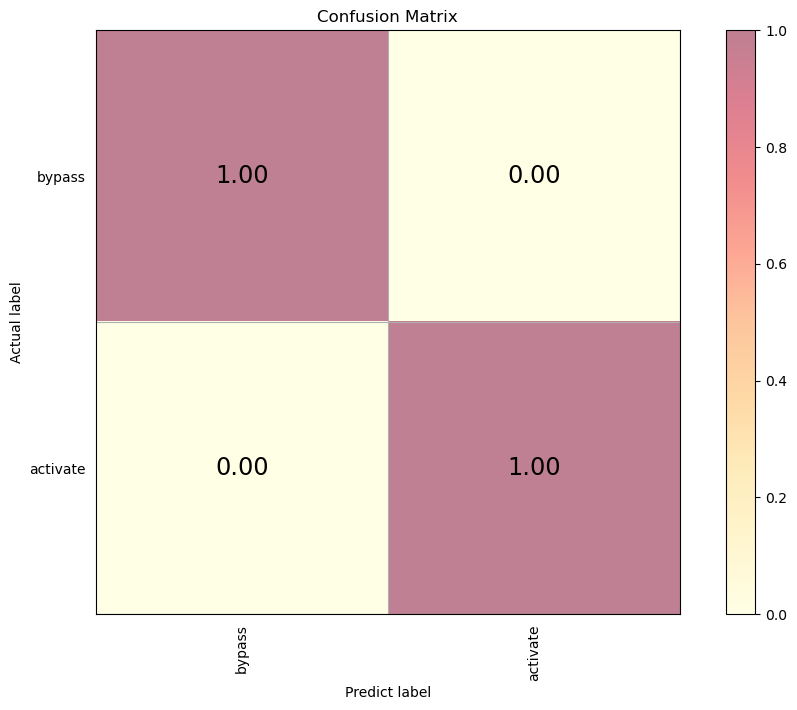

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
from src.util import plot_confusion_matrix

labels_ID = ['bypass', 'activate']

cnn = model.Classifier().to(device)

state_dict = torch.load(WEIGHTS_FILE)
cnn.load_state_dict(state_dict)

log = train.test(cnn, val_dataloader, device, mode="multi")

for i in range(5):
    expected = []
    predicted = []
    for index, data in enumerate(log[i]):
        predicted.append(data[1])
        expected.append(data[2])
    mat_con = confusion_matrix(y_true=expected, y_pred=predicted)
    print(mat_con)
    plot_confusion_matrix(mat_con, title='Confusion Matrix', classes=labels_ID)
